In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import classification_report, accuracy_score, f1_score
import itertools

In [2]:
#file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025.csv"
file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025_norge.csv"
df = pd.read_csv(file_path, sep=";")

In [3]:
df = df[df["EGS.VEDTAK.10670"].notna()]

In [4]:
df['Avslag_ind'] = df['EGS.VEDTAK.10670'].apply(lambda x: 1 if x == "Avslag" else 0)

In [5]:
if "Kurvatur, horisontalelement" in df.columns:
    df["Kurvatur, horisontal"] = df["Kurvatur, horisontalelement"]

In [6]:
features = [
    'Avslag_ind',
    "ÅDT, total",
    "ÅDT, andel lange kjøretøy",
    "Fartsgrense",
    "Avkjørsel, holdningsklasse",
    "Funksjonsklasse",
    "Avkjørsler",
    "Trafikkulykker",
    "EGS.BRUKSOMRÅDE.1256", 
    "Kurvatur, horisontal", 
    "Kurvatur, stigning"
]

# Encode categorical features
df_encoded = pd.get_dummies(df[features])

In [7]:
df_encoded=df_encoded.dropna()

In [8]:
df_encoded['sving_ind'] = np.where(df_encoded['Kurvatur, horisontal'].abs() > 99000, 0, 1)
df_encoded['bakke']=df_encoded['Kurvatur, stigning'].abs()
df_encoded['bakke_ind'] = np.where(df_encoded['Kurvatur, stigning'].abs() > 0.1, 1, 0)
df_encoded['sving_sigmoid'] = np.where(df_encoded['Kurvatur, horisontal'].abs() < 99000, 1/(1+np.exp(-0.001*df_encoded['Kurvatur, horisontal'].abs())), 0)
df_encoded['antall_lange_kj']=df_encoded['ÅDT, total']*df_encoded['ÅDT, andel lange kjøretøy']/100
df_encoded = df_encoded.drop(['Kurvatur, horisontal', 'Kurvatur, stigning'], axis=1)
y = df_encoded['Avslag_ind']        # target
X = df_encoded.drop(columns=['Avslag_ind'])  # all other columns

In [9]:
poly = PolynomialFeatures(4, include_bias=False, interaction_only=True) 
X = pd.DataFrame(
    poly.fit_transform(X),
    columns=poly.get_feature_names_out(X.columns)
)

In [10]:
scaler = PowerTransformer()
X = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

In [11]:
from sklearn.decomposition import PCA

n_components = 100
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X)

# Auto-generate names: PC1, PC2, ..., PCn
pc_names = [f"PC{i+1}" for i in range(n_components)]

X_pca_df = pd.DataFrame(X_pca, columns=pc_names, index=X.index)

print("Explained variance ratio:", sum(pca.explained_variance_ratio_))
print("Shape after PCA:", X_pca_df.shape)
print(X_pca_df.head())


Explained variance ratio: 0.5643288576665394
Shape after PCA: (856, 25)
         PC1        PC2       PC3        PC4       PC5        PC6        PC7  \
0 -23.377509 -14.536347  1.518438   8.555537 -3.475539   8.406598   0.461727   
1 -20.858159 -18.926424  7.277239  26.547409 -7.168370  11.241767   0.577368   
2  -7.639778  15.569253 -3.404680 -15.151667 -1.600787   8.047480  -3.653067   
3  12.479562  -4.417431 -3.021339 -26.379497 -1.428694  -2.991948 -17.135433   
4 -12.139080   6.944432 -1.487138  -7.137308 -3.714726  13.239296  -3.513888   

        PC8       PC9       PC10  ...       PC16       PC17      PC18  \
0  0.337282 -3.352249  -6.393330  ...   0.798163   6.570721  1.024059   
1  2.087928 -3.784098  -6.697100  ...   0.014939 -14.119362 -3.567895   
2 -2.320052 -2.041447  -6.360242  ...   2.754444   3.720154 -0.823729   
3  8.813450  7.441752 -19.448949  ... -31.705324  -5.166018 -1.981061   
4  2.342626 -6.497508  -9.807181  ...   5.223537  -2.987197  2.400970   

        

In [12]:
#X=X_pca_df

In [13]:
X

,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,Avkjørsler,Trafikkulykker,"Avkjørsel, holdningsklasse_Lite streng","Avkjørsel, holdningsklasse_Meget streng","Avkjørsel, holdningsklasse_Mindre streng","Avkjørsel, holdningsklasse_Streng",Funksjonsklasse_A - Nasjonale hovedveger,...,EGS.BRUKSOMRÅDE.1256_Skole/Barnehage sving_ind sving_sigmoid antall_lange_kj,EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke bakke_ind sving_sigmoid,EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke bakke_ind antall_lange_kj,EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke sving_sigmoid antall_lange_kj,EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke_ind sving_sigmoid antall_lange_kj,sving_ind bakke bakke_ind sving_sigmoid,sving_ind bakke bakke_ind antall_lange_kj,sving_ind bakke sving_sigmoid antall_lange_kj,sving_ind bakke_ind sving_sigmoid antall_lange_kj,bakke bakke_ind sving_sigmoid antall_lange_kj
0,-1.723294,0.029680,1.088215,-1.569219,-1.048636,1.518229,-0.206473,-0.494152,-0.501460,-0.034199,...,-0.048393,-0.048393,-0.059304,-0.048393,-0.048393,0.939136,0.310813,0.266110,0.111440,0.290005
1,0.383912,0.950345,-1.027326,-1.569219,1.079252,1.518229,-0.206473,-0.494152,-0.501460,-0.034199,...,-0.048393,-0.048393,-0.059304,-0.048393,-0.048393,1.533423,1.481839,1.449764,1.078246,1.442544
2,0.329036,0.029680,-0.377069,-1.569219,-1.048636,-0.658662,-0.206473,2.023669,-0.501460,-0.034199,...,-0.048393,-0.048393,-0.059304,-0.048393,-0.048393,-0.981470,-1.047379,-1.067447,-1.044651,-1.040329
3,2.063733,0.534235,-1.027326,-1.569219,1.872248,-0.658662,4.843257,-0.494152,-0.501460,-0.034199,...,-0.048393,-0.048393,-0.059304,-0.048393,-0.048393,-0.981470,-1.047379,-1.067447,-1.044651,-1.040329
4,0.064912,0.950345,-1.027326,-1.160739,0.611224,1.518229,-0.206473,-0.494152,-0.501460,-0.034199,...,-0.048393,-0.048393,-0.059304,-0.048393,-0.048393,-0.981470,-1.047379,-1.067447,-1.044651,-1.040329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,0.760973,-1.443492,-2.136054,1.379377,-1.048636,1.518229,-0.206473,-0.494152,-0.501460,-0.034199,...,-0.048393,-0.048393,-0.059304,-0.048393,-0.048393,-0.122369,0.439895,0.502985,1.102338,0.522990
852,-0.105697,0.029680,-0.377069,0.620790,0.611224,-0.658662,-0.206473,2.023669,-0.501460,-0.034199,...,-0.048393,-0.048393,-0.059304,-0.048393,-0.048393,-0.598583,-0.041502,-0.051031,0.888517,-0.023587
853,-0.317948,0.751545,-0.377069,0.620790,-1.048636,-0.658662,-0.206473,-0.494152,1.994178,-0.034199,...,-0.048393,-0.048393,-0.059304,-0.048393,-0.048393,1.332001,1.102716,1.071127,0.771354,1.077164
854,0.940522,1.133297,1.088215,0.169913,1.317421,-0.658662,-0.206473,-0.494152,1.994178,-0.034199,...,-0.048393,-0.048393,-0.059304,-0.048393,-0.048393,1.008420,1.385243,1.415090,1.425179,1.409225


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [15]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import PredefinedSplit

# Define the parameter distributions
param_dist = {
    'n_estimators': randint(100, 500),
     'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 25),
    'sampling_strategy': uniform(0.1, 0.6)
    #'max_leaf_nodes': randint(10, 100)
}

model = BalancedRandomForestClassifier(random_state=42, n_jobs=1, replacement=True, bootstrap=True)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=100,                  # number of random combinations to try
    #cv=ps,
    cv=4,
    scoring="average_precision",
    n_jobs=1,
    verbose=1,
    random_state=42
)
random_search.fit(X_train, y_train)
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
Best parameters: {'max_depth': 28, 'min_samples_split': 2, 'n_estimators': 235, 'sampling_strategy': 0.10331327027416144}
Best score: 0.14794562490151433


In [16]:
model = BalancedRandomForestClassifier(random_state=42, n_jobs=-1, replacement=True, bootstrap=True, sampling_strategy=0.15, n_estimators=1000)

In [17]:
model.fit(X_train, y_train)

BalancedRandomForestClassifier(bootstrap=True, n_estimators=1000, n_jobs=-1,
                               random_state=42, replacement=True,
                               sampling_strategy=0.15)

In [21]:
y_pred=random_search.predict(X_test)
y_proba=random_search.predict_proba(X_test)[:,1]

In [22]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9801    0.9801    0.9801       251
           1     0.1667    0.1667    0.1667         6

    accuracy                         0.9611       257
   macro avg     0.5734    0.5734    0.5734       257
weighted avg     0.9611    0.9611    0.9611       257



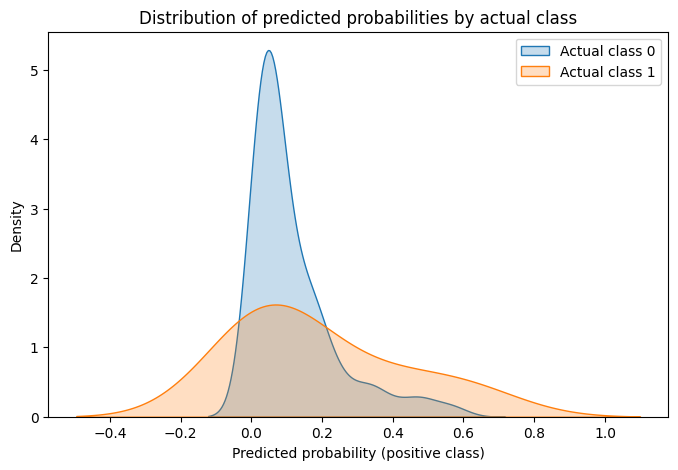

In [23]:
df_plot = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})

# Plot distributions
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot[df_plot['y_test'] == 0]['y_proba'], label='Actual class 0', fill=True)
sns.kdeplot(data=df_plot[df_plot['y_test'] == 1]['y_proba'], label='Actual class 1', fill=True)
plt.title("Distribution of predicted probabilities by actual class")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Density")
plt.legend()